# Classification d'images avec un réseau pleinement connecté et PyTorch

Au dernier TP, nous avons exploré les bases de PyTorch pour une régression linéaire et un tout petit réseau neuronal (XOR).

Nous aurons besoin de PyTorch pour ce Notebook. S'il n'est pas déjà installé, référez vous au dernier TP pour le faire.

Nous aurons aussi besoin d'opencv pour manipuler certaines images. Vous pouvez l'installer avec `pip install opencv-python`.

Aujourd'hui, nous verrons un cas plus réaliste où le but est de classifier des données.
Nous allons créer un réseau de neurones simple pour classifier des images de la base de données « [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) ».
Cet ensemble a été créé pour fournir une alternative à la base de données MNIST (les chiffres écrits à la main).
Nous allons utiliser cet exemple car il est assez rapide à analyser pour le faire sur CPU, et aussi car un perceptron multi-couche (_MLP_) simple
performe relativement bien sur ces images.

## Données

Contrairement à ce que nous avons fait depuis le début de la session, où l'on performait principalement des tâches de _régression_, l'exemple ci-dessous s'intéresse à la classification.
Pour les problèmes de classification, les données sont souvent des images.
Numériquement, une image n'est rien d'autre qu'un tableau (tenseur) avec des valeurs numériques.
Elles ont typiquement 3 dimensions: `(couleur, X, Y)`. La dimension de couleur a généralement une longueur de 3 pour une image RGB (itensité de chaque pixel en rouge, bleu et vert).
Pour une image à une seule couleur (en noir et blanc), la dimension couleur aura une longueur 1.

### Téléchargement avec PyTorch

PyTorch inclut une classe `Dataset` qui permet d'organiser efficacement des données, incluant les catégories pour les données de test et d'entraînement.
On peut définir un `Dataset` avec nos propres données, mais pour les tests ou les exmples, PyTorch inclut des ensembles de données pré-définis.
On peut donc télécharger et importer les données _MNIST Fashion_ directement.

In [1]:
from torchvision import datasets

In [2]:
training_data = datasets.FashionMNIST(
    root="data",  # Dir où on va sauvegarder les données
    train=True,  # Pour dataset existant, train=True importe les données d'entraînement
    download=True,
)

In [3]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

`training_data` est un object `Dataset` qui contient 60 000 images.
On aurait également pu accéder au nombre d'images avec `len(training_data)`

In [4]:
# Le dataset comporte un tenseur et un label par élément
print(training_data)
print("Nombre d'images:", len(training_data))

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
Nombre d'images: 60000


### Images en Python et librairie PIL (Pillow)

Pour accéder au premier élément, on utilise la syntaxe Python habituelle:

In [5]:
training_data[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

On voit que chaque exemple ne contient pas seulement l'image, mais aussi un chiffre. Ce chiffre dénote la classe à laquelle l'image appartient.
Pour connaître la signification de chaque chiffre, on peut se référer à [la page GitHub de Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist?tab=readme-ov-file#labels).
On peut mettre le tout dans un dictionnaire pour facilement identifier les objets.

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
inv_labels_map = dict(zip(labels_map.values(), labels_map.keys()))

Quant au premier élément du tuple ci-dessus, il s'aggit d'une image au format « Python Image Library » (PIL ou `pillow`).
Cette librarie permet de manipuler des images en Python ([tutoriel ici](https://pillow.readthedocs.io/en/stable/handbook/tutorial.html#)).
Dans notre cas, nous convertirons généralement les images vers des tenseurs PyTorch, mais explorons d'abord un peu Pillow.

In [7]:
example_img, example_label = training_data[0]

In [8]:
print("Type d'article:", labels_map[example_label])
print("Infos sur l'image:", example_img.format, example_img.size, example_img.mode)

Type d'article: Ankle Boot
Infos sur l'image: None (28, 28) L


Les informations ci-dessus nous donnent le format d'entrée (None ici comme PyTorch avait compressé l'image), la taille de l'image et le mode (L pour noir et blanc, RGB pour couleurs).

Pour afficher l'image, on peut utiliser Matplotlib directement.
On utilise `cmap="binary"` pour des couleurs plus intuitives.

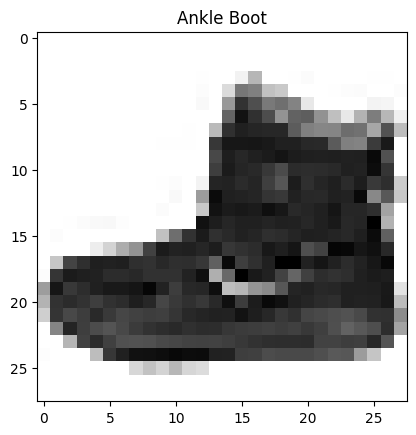

In [9]:
import matplotlib.pyplot as plt

plt.imshow(example_img, cmap="binary")
plt.title(labels_map[example_label])
plt.show()

Pillow nous permet aussi de faire certaines transormations de base avec nos images, par exemple un découpage ou une rotation.

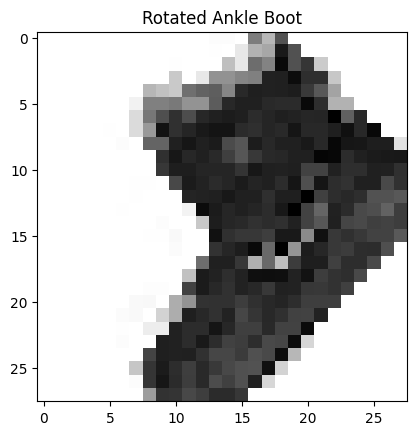

In [10]:
plt.imshow(example_img.rotate(45), cmap="binary")
plt.title("Rotated " + labels_map[example_label])
plt.show()

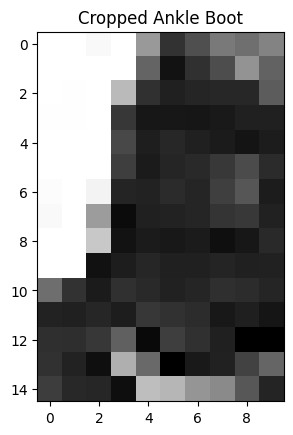

In [11]:
plt.imshow(example_img.crop((10, 5, 20, 20)), cmap="binary")
plt.title("Cropped " + labels_map[example_label])
plt.show()

Et on peut convertir les données vers un tableau NumPy.
Pour une image en noir et blanc, on aura un tableau 28x28 avec des valeurs entre 0 et 255.
Pour une image RGB, le format aurait été `(3, 28, 28)`.

In [12]:
import numpy as np

img_arr = np.array(example_img)
print(img_arr.shape)
print(img_arr.min(), img_arr.max())

(28, 28)
0 255


### Images avec PyTorch

Pour utiliser les images dans un modèle PyTorch, on doit les convertir en tenseur.
L'utilité `ToTensor()` nous permet de le faire facilement.

In [13]:
from torchvision.transforms import ToTensor

In [14]:
img_converter = ToTensor()
img_tensor = img_converter(example_img)

In [15]:
print(img_tensor.shape)
print(img_tensor.min(), img_tensor.max())

torch.Size([1, 28, 28])
tensor(0.) tensor(1.)


On remarque deux choses:

- PyTorch inclut toujours la dimension de couleur, donnant `(1, 28, 28)`.
- PyTorch normalise les images entre 0 et 1.

**On peut appliquer la transformation `ToTensor()` à tous nos exemples automatiquement.**

In [16]:
training_data = datasets.FashionMNIST(
    root="data",  # Dir où on va sauvegarder les données
    train=True,  # Pour dataset existant, train=True importe les données d'entraînement
    download=True,
    transform=ToTensor(),  # Transformation de tableau PIL vers tenseur
)

In [17]:
print(training_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [18]:
print(type(training_data[0][0]))
print(training_data[0][0].shape)

<class 'torch.Tensor'>
torch.Size([1, 28, 28])


Remarquez l'argument `train=True` ci-dessus.
Il dit à PyTorch de n'importer que les données d'entraînement dans notre ensemble.
Avec `train=False`, on peut importer les données test.

**Exercice: Importez les données test dans un objet `test_data` et imprimez l'ensemble.**

In [19]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [20]:
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


On peut également afficher les données directement à partir du format PyTorch.
Par contre, Matplotlib s'attend à ce que la dimension « couleur » soit en 3e, pas en 1er...
On a donc deux choix: utiliser l'image 2D (OK pour des données noir et blanc) ou réordonner les axes avec `permute()`.

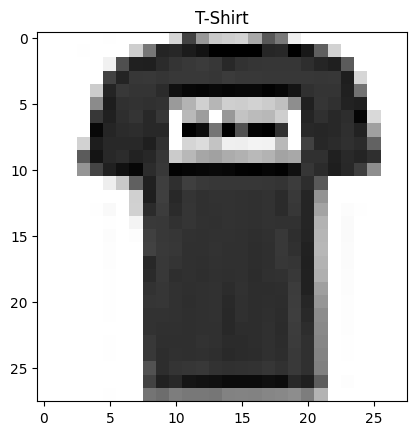

In [21]:
# Ici, on envoie l'axe 0 en dernière position et on garde 1 et 2 dans l'ordre initial.
plt.imshow(training_data[1][0].permute(1, 2, 0), cmap="binary")
plt.title(labels_map[training_data[1][1]])
plt.show()

On peut se définir une fonction qui affichera des images pour le reste de l'exemple.

In [22]:
import torch

def plot_grid(data):
    """
    Fonction pour tirer 9 images au hasard d'un Dataset PyTorch et les fafficher
    """
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # On tire une image au hasard et on l'affiche
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0), cmap="binary")
    return figure

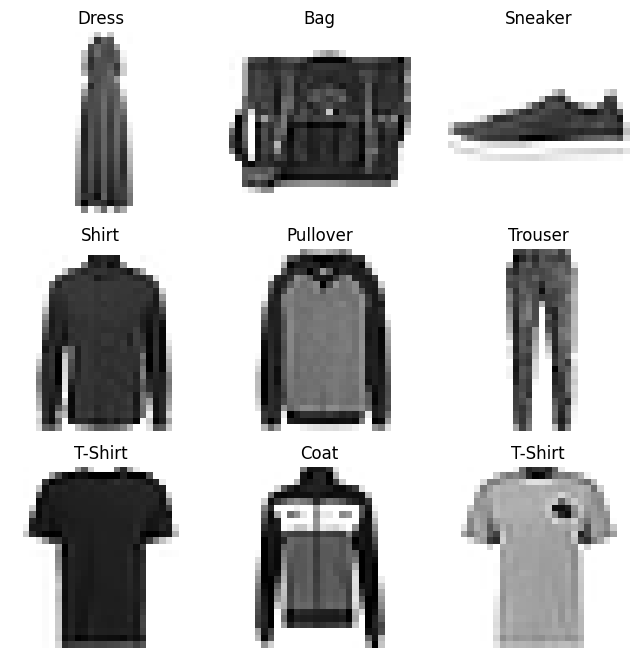

In [23]:
plot_grid(training_data)
plt.show()

### Dataloader: séparer les données en sous-ensembles

Le `Dataset` organise déjà les images en ensemble d'entraînement et de test, mais ne permet pas de les séparer en sous-ensembles (_batches_) ou de les mélanger avant l'entraînement.
Pour ce faire, on utilise la classe `Dataloader`. Cette dernière prend un `Dataset` en entrée et le sépare en sous-ensemble.

En créant les `DataLoader` ci-dessous, on spécifie en argument:

- L'ensemble de données
- La taille des sous-ensembles (nombre d'images analysées pour chaque pas de la descente de gradient)
- `suffle=True` pour re-brasser les sous-ensembles à chaque époque.

In [24]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

On peut vérifier le nombre de sous-ensembles:

In [25]:
print("Nombre de sous-ensembles pour l'entraînement:", len(train_dataloader))
print("Nombre de sous-ensembles pour la phase test:", len(test_dataloader))

Nombre de sous-ensembles pour l'entraînement: 938
Nombre de sous-ensembles pour la phase test: 157


On peut voir que les 60 000 exemples d'entraînement on été séparés en groupes de 64 (sauf pour le dernier).

On peut aussi essayer d'accéder aux données...

In [26]:
try:
    train_dataloader[0]
except Exception as e:
    print("Erreur:", e)

Erreur: 'DataLoader' object is not subscriptable


Comme on peut voir ici, on ne peut pas simplement indexer le `Dataloader`.
La façon de s'en servir est normalement avec une boucle.

In [27]:
for i, batch in enumerate(train_dataloader):
    if i == 0:
        print("Premier sous-ensemble")
        print("  Type du sous-ensemble", type(batch))
        print("  Longueur du sous-ensemble", len(batch))
        print("  Format des images:", batch[0].shape)
        print("  Format des annotations", batch[1].shape)
    elif i == (len(train_dataloader) - 1):
        print()
        print("Dernier sous-ensemble:")
        print("  Forrmat des images:", batch[0].shape)
    else:
        print(".", end="")

Premier sous-ensemble
  Type du sous-ensemble <class 'list'>
  Longueur du sous-ensemble 2
  Format des images: torch.Size([64, 1, 28, 28])
  Format des annotations torch.Size([64])
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Pour accéder à un seul exemple du `Dataloader`, on peut créer un itérateur avec `iter()` et lui demander le prochain exemple avec `next()`.
Ce processus est similaire à ce que fait la boucle `for` normalement.

On peut ainsi accéder à un seul sous-ensemble sans faire une boucle.
Et comme nous avons spécifié `shuffle=True`, on obtient un rebrassage à chaque fois que l'on utilise `iter()`.

Format des images: torch.Size([64, 1, 28, 28])
Format des annotations: torch.Size([64])


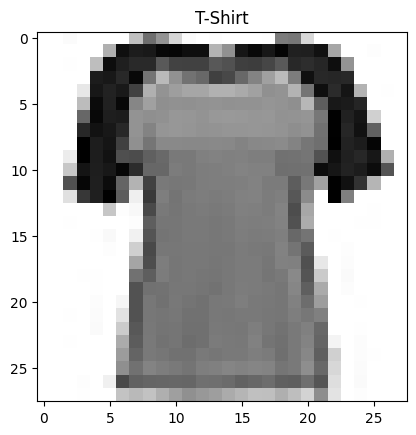

In [28]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Format des images: {train_features.size()}")
print(f"Format des annotations: {train_labels.size()}")

# On extrait le premier exemple du sous-ensemble
img = train_features[0].squeeze()  # On laisse tomber la dimension "couleur"
label = train_labels[0]
plt.imshow(img, cmap="binary")
plt.title(labels_map[train_labels[0].item()])
plt.show()

## Définition d'un modèle

Les données sont bien formattées.
On peut maintenant passer à la définition et l'entraîenement d'un modèle!

On pourrait définir un réseau avec les éléments de base de PyTorch, c'est à dire des tenseurs, de l'algèbre matriciel et `autograd`.
Par contre, tel que vu au dernier cours, PyTorch nous rend la vie plus facile avec la librairie `torch.nn`, qui fait les opérations générales à notre place.
On peut donc définir notre modèle sans écrire explicitement toutes les opérations, mais en nous concentrant plutôt sur la structure.

Si vous voulez voir comment on implémenterait un réseau sans `torch.nn`, ce tutoriel PyTorch donne un exemple intéressant: https://pytorch.org/tutorials/beginner/nn_tutorial.html

In [29]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

Nous avons vu au dernier cours que `torch.nn` utilise une interface orientée objet: les modèles sont des _classes_ et on implémente des _méthodes_ pour créer le modèle.

### Programmation orientée objet: rappel rapide

La définition d'un modèle avec `torch.nn` requiert des connaissances de base de la programmation orientée objet:
- Une classe est un type d'objet (comme `int`, `bool` ou `torch.Tensor`) que l'on définit nous mêmes
- Les classes ont des attributs et des méthodes (fonction qui agissent sur l'objet, comme `"point".replace("t", "g")` qui retourne "poing")
- `nn.Module` est une classe de base pour les modèles PyTorch. Elle définit les différentes opérations de bases d'un réseau de neurones
- On peut créer une sous-classe qui héritera de ces caractéristiques, tout en y ajoutant de nouvelles caractéristiques plus spécifiques
- La méthode `__init__` est la méthode qui permet de créer un objet (ce qui serait exécuté quand on utilise `a = np.array([1,2,3])` par exemple. `[1,2,3]` est un argument de la fonction `__init__`)

### Création d'un réseau pleinement connecté pour la classification d'images

#### Couche par couche

Dans l'exemple XOR du cours précédent, nous avons vu tous les blocs de base permettant de définir un réseau neuronal pleinement connecté.

**Exercice: Implémentez le réseau décrit ci-dessous à l'aide de `torch.nn`.**

- On convertit l'image vers un vecteur 1D (entrées $x$) `nn.Flatten()`
- Une couche pleinement connectée de 512 neurones (cachée $h_1$)
- Une autre couche pleinement connectée de 512 neurones (cachée $h_2$)
- Une dernière couche donnant les logits (log-probablité non-normalisée) pour chaque catégorie (sortie $y$)
- Activations `nn.ReLU()` pour les couches internes


Comme nous avons fait dans l'exemple XOR, définissez les couches et les fonctions dans `__init__()`, puis réutilisez les dans la méthode `forward`.

**NOTE: Plus bas nous utiliserons [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) comme fonction objectif. Cette fonction s'attend à des logits en entrée. Nous n'avons donc pas à utiliser nn.Softmax directement ici, car `nn.CrossEntropyLoss` le fait pour nous.**

In [30]:
class SimpleNetworkNoSeq(nn.Module):
    def __init__(self):
        super(SimpleNetworkNoSeq, self).__init__()
        # Image -> vecteur
        # On va souvent répéter l'opération. On peut l'attacher à notre classe
        self.flatten = nn.Flatten()

        # D'abord, on crée les fonctions qu'on va utiliser dans le réseau
        self.activation = nn.ReLU()  # On va toujours utiliser ReLU ici
        self.linear1 = nn.Linear(
            28 * 28, 512
        )  # Pleinement connecté 28*28 (image) -> 512
        self.linear2 = nn.Linear(512, 512)
        self.linear_last = nn.Linear(512, 10)  # On map vers nos 10 classes
        # NOTE: Softmax est implémenté dans certaines loss functions.
        # Sinon on ajouterait ceci et  on l'ajouterait dans nos étapes de `forwrad`.
        # self.softmax = nn.Softmax()  # On map vers nos 10 classes

    def forward(self, x):
        # Cette fonction fera passer l'info dans le réseau, l'input x est un tenseur d'image
        # On aplatit l'image
        x = self.flatten(x)
        # On fait passer dans les différentes couches
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        # Logits désigne les valeurs à la sortie
        logits = self.linear_last(x)
        return logits

Le réseau est implémenté! On peut en créer une instance avec `model_noseq = SimpleNetworkNoSeq()`.

In [31]:
model_noseq = SimpleNetworkNoSeq().to(device)

**Exercice: Accédez à la 50e image des données d'entraînement et donnez-la en entrée au modèle. Ajoutez une dimension additionnelle à la position 0 avec `.unsqueeze()` pour simuler un sous-ensemble de longueur 1. Affichez la valeur de retour et son format (size).**

In [32]:
img_example, label_example = training_data[50]

In [33]:
out_example = model_noseq(img_example.unsqueeze(0))
print(out_example)
print(out_example.shape)

tensor([[ 0.0598,  0.0384,  0.0411, -0.0246,  0.0506, -0.1202,  0.0432, -0.0261,
         -0.0282,  0.0332]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


On voit que les « scores » sont donnés en _logits_.
Remarquez aussi que `grad_fn` est défini!

On peut les convertir vers des probabilités avec `torch.nn.functional.softmax`.
Il faut spécifier sur quelle dimension on veut normaliser.

In [34]:
prob_example = nn.functional.softmax(out_example, dim=1)
print(prob_example)

tensor([[0.1053, 0.1031, 0.1034, 0.0968, 0.1043, 0.0880, 0.1036, 0.0966, 0.0964,
         0.1025]], grad_fn=<SoftmaxBackward0>)


`nn.functional` est une interface fonctionnelle aux objets de `torch.nn`.
On aurait également pu utiliser.

In [35]:
nn.Softmax(dim=1)(out_example)

tensor([[0.1053, 0.1031, 0.1034, 0.0968, 0.1043, 0.0880, 0.1036, 0.0966, 0.0964,
         0.1025]], grad_fn=<SoftmaxBackward0>)

**Exercice: Vérifiez que les probabilités sont bien normalisées**

In [36]:
print("Somme des probabilités", prob_example.sum(axis=1))

Somme des probabilités tensor([1.0000], grad_fn=<SumBackward1>)


#### Implémentation avec `nn.Sequential`

Le réseau ci-dessus fonctionne, mais la série d'opérations sur x est un peu répétitive dans `forward()`. 
C'est le cas pour beaucoup de réseaux.
`nn.Sequential` permet de directement définir une chaine d'opérations.
On fait appelle à cette chaîne directement dans `forward()`

**Consultez la documentation pour nn.Sequential et implémentez le réseau ci-dessus, mais en utilisant `nn.Sequential` pour tout sauf `Flatten`.**

In [37]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        # Image -> vecteur
        # On va souvent répéter l'opération. On peut l'attacher à notre classe
        self.flatten = nn.Flatten()

        # Sequential permet d'enchainer les couches et les fonctions d'activations
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),  # Pas de ReLU pour la dernière couche: sorties
        )
        # NOTE: Softmax est implémenté dans certaines loss functions.
        # Sinon on ajouterait ceci et  on l'ajouterait dans nos étapes de `forwrad`.
        # self.softmax = nn.Softmax()  # On map vers nos 10 classes

    def forward(self, x):
        x = self.flatten(x)
        # Au lieu d'enchainer les étapes, on utilise directement Sequential
        logits = self.linear_relu_stack(x)
        return logits

#### Comparaison des deux implémentations

Mathématiquement, les deux modèles devraient faire exactement la même chose.

**Exercice: Créez une instance `model` de `SimpleNetowrk`. Imprimez `model` et `model_noseq` pour les comparer. Testez le résultat de `model` sur l'image 50, comme plus haut. Comparez les valeurs de sorties avec le modèle « non séquentiel ». Les valeurs sont-elles les même? Pourquoi?**

In [38]:
model = SimpleNetwork().to(device)

In [39]:
print(model_noseq)
print(model)

SimpleNetworkNoSeq(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ReLU()
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear_last): Linear(in_features=512, out_features=10, bias=True)
)
SimpleNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [40]:
out_example_seq = model(img_example.unsqueeze(0))
print(out_example_seq)
print(out_example)

tensor([[ 0.0248,  0.0573, -0.0051, -0.0626, -0.0506, -0.0061, -0.0162, -0.0006,
         -0.0151, -0.0025]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0598,  0.0384,  0.0411, -0.0246,  0.0506, -0.1202,  0.0432, -0.0261,
         -0.0282,  0.0332]], grad_fn=<AddmmBackward0>)


Les valeurs sont différentes car les poids utilisés pour initialiser le modèle sont différents: cette initialisation est faite de manière aléatoire.

On peut forcer une stratégie d'initialisation des poids avec `nn.init`.

In [41]:
# Pour vérifier les structures, on peut forcer les poids à être identiques
def init_const(m):
    # Fonction destinée à nn.Model.apply()
    # m est une couche du réseau. Si c'est une couche linéaire, on ajuste les paramètres
    if isinstance(m, nn.Linear):
        # Plusieurs autres distributions disponibles dans le module nn.init
        # Ici on utilise des valeurs déterministiques pour notre test
        nn.init.constant_(m.bias.data, 0.0)
        # matrice identité pour ne pas avoir des activations égales partout
        nn.init.eye_(m.weight.data)


model.apply(init_const)
model_noseq.apply(init_const)
print(model(img_example.unsqueeze(0)))
print(model_noseq(img_example.unsqueeze(0)))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
         0.0000]], grad_fn=<AddmmBackward0>)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
         0.0000]], grad_fn=<AddmmBackward0>)


In [42]:
# Réinitialisation du modèle
model = SimpleNetwork().to(device)

**Exercice: Explorez `model.parameters()` et `model.named_parameters()`. Combien de paramètres y a-t-il au total dans le modèle?**

### Prédiction avec le réseau non entraîné

Pour l'instant, notre réseau n'est pas entraîné.
Il y a tout de même quelques opérations que nous voudrons souvent répéter.
Ce serait un bon moment pour implémenter quelques fonctions qui nous aideront à:

- Tester le modèle sur une image donnée.
- Afficher l'image et les probabilités prédites par le modèle.

#### Fonction pour tester le modèle

In [43]:
def try_model(img, mod):
    """
    Fonction qui teste le modèle et retourne les probabilités pour chaque classe
    """
    logits = mod(img.unsqueeze(0))
    pred_probab = nn.Softmax(dim=1)(logits)
    y_pred = pred_probab.argmax(1)
    print(f"Catégorie prédite: {labels_map[y_pred.item()]}, probabilité de {pred_probab.max():.3f}")

    return pred_probab

**Exercice: Testez le modèle sur une image composée de bruit uniforme générée avec `torch.rand`.**

In [44]:
X = torch.rand(1, 28, 28, device=device)
preds = try_model(X, model);  # noqa

Catégorie prédite: T-Shirt, probabilité de 0.116


#### Fonctions d'affichage

Une bonne façon de visualiser la sortie est d'afficher l'image avec un histogramme des probabilités.
Les fonctions d'affichage sont tirées de ce tutoriel TensorFlow: https://www.tensorflow.org/tutorials/keras/classification.

In [45]:
def plot_image(predictions_array, true_label, img, cmap="binary"):
    # true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=cmap)

    predicted_label = torch.argmax(predictions_array).item()
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            labels_map[predicted_label],
            100 * torch.max(predictions_array),
            "None" if true_label is None else labels_map[true_label],
        ),
        color=color,
    )


def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array.numpy(), color="#777777")
    plt.ylim([0, 1])
    predicted_label = torch.argmax(predictions_array).item()

    thisplot[predicted_label].set_color("red")
    if true_label is not None:
        thisplot[true_label].set_color("blue")

On peut tester ces fonctions sur notre image aléatoire.

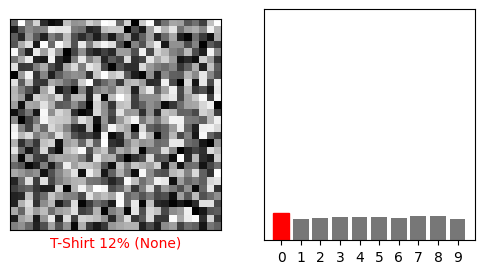

In [46]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), None, X.squeeze().detach())
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), None)
plt.show()

On peut également la tester sur une vraie image

**Exercice: Copiez la cellule ci-dessus, mais utilisez une image tirée de l'ensemble d'entraînement et son annotation.**

Catégorie prédite: T-Shirt, probabilité de 0.120


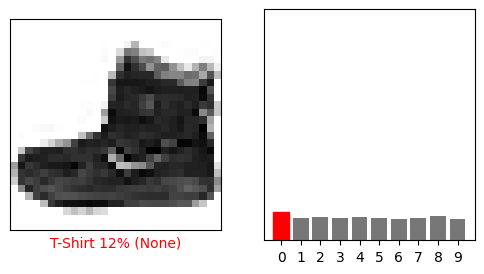

In [47]:
img, label = training_data[0]
preds = try_model(img, model)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), None, img.squeeze().detach())
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), None)
plt.show()

## Entraînement

Maintenant que le modèle est définit, on peut l'entraîner pour qu'il puisse mieux classifier les images.

In [48]:
# Nouveau modèle, pour effacer nos manipulations dans la section d'avant
model = SimpleNetwork().to(device)

### Sélection des hyperparamètres

D'abord, il faut choisir les hyperparamètres (les valeurs pré-définies qui affectenent l'entraînement)
- Époques: nombre d'itérations  sur les données complètes
- Sous-ensembles: nombre d'exemples donnés aux modèle avant de mettre à jour les paramètres
- Learning rate: Taux de changement à chaque mise à jour des paramètres

In [49]:
epochs = 10
batch_size = 64
learning_rate = 1e-3

### Fonction objectif
Il faut aussi choisir une fonction objectif qui caractérise la perormance du modèle.
`CrossEntropyLoss` combine softmax et negative log-likelihood.
Cette fonction distingue mieux les très mauvais modèles des modèles presque adéquats
que la fonction "Mean Square error".

In [50]:
loss_fn = nn.CrossEntropyLoss()

### Optimiseur
L'optimisation se fera avec une descente de gradient stochastique

**Exercice: Créez une variable `optimizer` qui définit une descente de gradient stochastique (SGD).**

In [51]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Boucles d'entraînement et test

#### Boucle d'entraînement

Une fois toutes nos fonction définies on peut faire l'entraînement.

**Exercice: Définissez une fonction `train_loop` qui complète une époque d'entraînement en itérant sur `dataloader`. La fonction doit retourner la valeur moyenne de la fonction objectif sur tous les exemples.**

Quelques rappels/suggestions:

- Insipirez-vous de notre boucle dans l'exemple XOR du dernier cours
- Il faut réinitialiser les paramètres à chaque étape, recaclculer le gradient avec PyTorch et faire faire un pas à notre optimiseur.
- Vous pouvez afficher la valeur de la fonction objectif à tous les 100 exemples pour suivre l'évolution du modèle.

In [52]:
def train_loop(dataloader, model, loss_fn, optimizer):

    # Taille de l'ensemble d'entraînement
    size = len(dataloader.dataset)

    # Itération sur les batches (dataloader nous donne les données par batch)
    # X est l'image et y la classe
    train_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        # Fonction objectif
        pred = model(X)  # prédiction
        loss = loss_fn(pred, y)

        # Rétropropagation
        optimizer.zero_grad()  # On réinitialise le gradient d'abord
        loss.backward()  # Rétropropagation
        optimizer.step()  # On fait un pas dans l'espace paramètre

        loss, current = loss.item(), batch * len(X)
        train_loss += loss * X.size(0)
        # Progrès
        if batch % 100 == 0:
            print(f"Loss: {loss}, [{current}/{size}]")

    return train_loss / size

#### Boucle de test (validation)

Pour chaque époque de l'entraînement, il sera aussi utile d'itérer sur les données test.
La boucle de test vérifie la performance sur des données non utilisées à l'entraînement.
On utilise seulement la propagation avant, donc pas besoin des gradients.
Cette boucle peut être utilisée à chaque époque pour voir l'évolution de l'entrainement.

Remarquez l'utilisation de `torch.no_grad()` qui permet d'éviter la propagation des gradients et de sauver du temps de calcul.

In [53]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = correct = 0

    # On se sauve les gradients comme ils ne sont pas utilisés
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  # Compute loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")

    return test_loss

Une fois les boucles d'entraînement et de test terminées, on peut itérer plusieurs
fois sur toutes les données

**Exercice: Utilisez les deux fonctions ci-dessus pour itérer sur les époques d'entraînement (`epochs`). Pour chaque époque, sauvegardez la valeur de la fonction objetif.**

In [54]:
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

Epoch 1
-------------------------------
Loss: 2.3100037574768066, [0/60000]
Loss: 2.2882614135742188, [6400/60000]
Loss: 2.2657604217529297, [12800/60000]
Loss: 2.2580199241638184, [19200/60000]
Loss: 2.24800181388855, [25600/60000]
Loss: 2.2295093536376953, [32000/60000]
Loss: 2.2014036178588867, [38400/60000]
Loss: 2.1950364112854004, [44800/60000]
Loss: 2.1697590351104736, [51200/60000]
Loss: 2.1556594371795654, [57600/60000]
Test Error: 
 Accuracy: 48.38%, Avg loss: 2.1459502991597366 

Epoch 2
-------------------------------
Loss: 2.152536153793335, [0/60000]
Loss: 2.1197595596313477, [6400/60000]
Loss: 2.0912392139434814, [12800/60000]
Loss: 2.0832338333129883, [19200/60000]
Loss: 2.0526034832000732, [25600/60000]
Loss: 2.0078299045562744, [32000/60000]
Loss: 1.9808040857315063, [38400/60000]
Loss: 1.9400440454483032, [44800/60000]
Loss: 1.9344570636749268, [51200/60000]
Loss: 1.9081252813339233, [57600/60000]
Test Error: 
 Accuracy: 58.379999999999995%, Avg loss: 1.8633496260187

**Exercice: Affichez sur en graphique la valeur de la fonction objectif en fonction du nombre d'époques. Affichez la valeur pour les données d'entraînement et de test.**

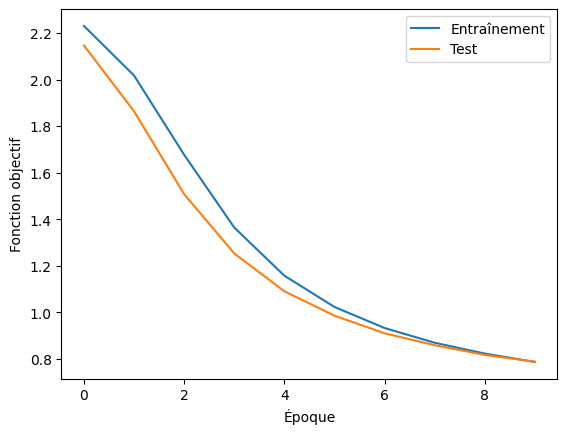

In [55]:
plt.plot(train_losses, label="Entraînement")
plt.plot(test_losses, label="Test")
plt.xlabel("Époque")
plt.ylabel("Fonction objectif")
plt.legend()
plt.show()

**Exercice: À la lumière de ce graphique, aurait-on avantage à entraîner le réseau plus longtemps?**

L'entraînement a pris un certain temps!
Ce ne serait pas une mauvaise idée de sauvegarder notre modèle.
On peut le faire à l'aide du `state_dict()` de notre modèle, qui emmagasine la valeur des paramètres.

In [56]:
torch.save(model.state_dict(), "./trained_mlp.pt")

In [57]:
model.load_state_dict(torch.load("./trained_mlp.pt", weights_only=True))

<All keys matched successfully>

## Inférence

On peut maintenant tester le modèle sur différents exemple.

### Bruit

D'abord, on peut voir comment le réseau répond à un bruit uniforme ou gaussien.
Le réseau a une confiance un peu élevée pour des images qui ne sont que du bruit.

Catégorie prédite: Bag, probabilité de 0.418


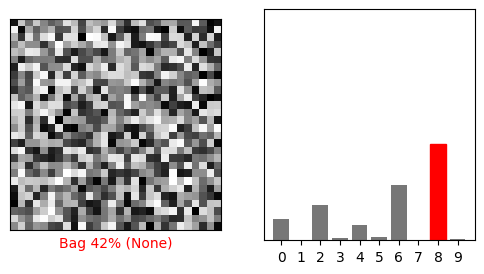

In [58]:
# Bruit uniforme
X = torch.rand(1, 28, 28, device=device)
preds = try_model(X, model)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), None, X.squeeze().detach())
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), None)
plt.show()

Catégorie prédite: Bag, probabilité de 0.251


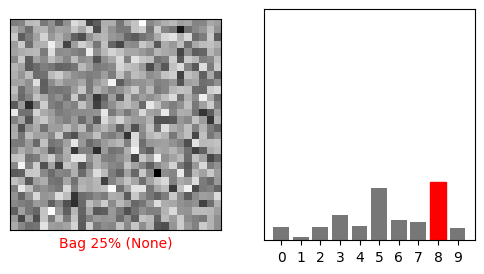

In [59]:
# Bruit Gaussien
X = torch.randn(1, 28, 28, device=device)
preds = try_model(X, model)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), None, X.squeeze().detach())
plt.subplot(1, 2, 2)

plot_value_array(preds.squeeze().detach(), None)
plt.show()

### Images Fashion MNIST

Pour les images de test ou d'entraînement, le réseau fonctionne, mais n'est pas parfait.
Certaines images similaires comme des souliers et des sandales sont plus difficiles à distinguer.
Les images pixelisées 28x28 et le réseau de neurones pleinement connecté n'aident pas.

Catégorie prédite: Sandal, probabilité de 0.392


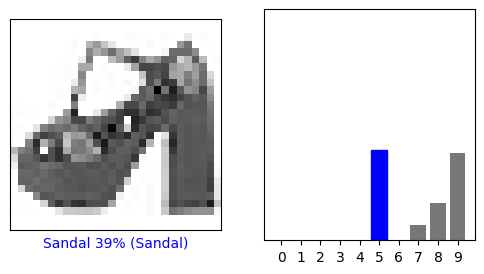

In [60]:
import random

i = random.randrange(len(training_data))
img, label = training_data[i]
preds = try_model(img, model)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), label, img.squeeze().detach())
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), label)
plt.show()

Catégorie prédite: Coat, probabilité de 0.366


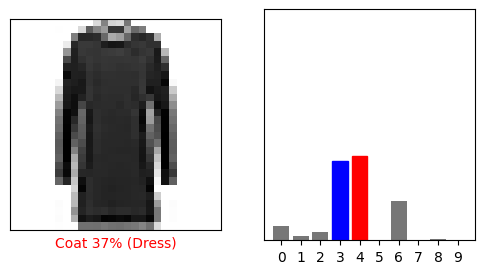

In [61]:
i = random.randrange(len(test_data))
img, label = test_data[i]
preds = try_model(img, model)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), label, img.squeeze().detach())
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), label)
plt.show()

**Exercice: Répétez les deux cellules ci-dessus quelques fois pour voir comment le réseau répond à différents exemples.**

Les images MNIST proviennent toutes d'une même source. On peut tester avec des images de vêtement
obtenues sur internet.

On peut aussi essayer de déjouer le réseau en lui donnant une image qui ne correspond à aucune catégorie.
Dans tous les cas, pour utiliser une image quelconque, il faut la formatter correctement.

On commence par importer l'image avec opencv.

In [62]:
import cv2

me = cv2.imread("photo_thomas_vandal.jpg", 0)  # 0 pour avoir une image "grayscale"

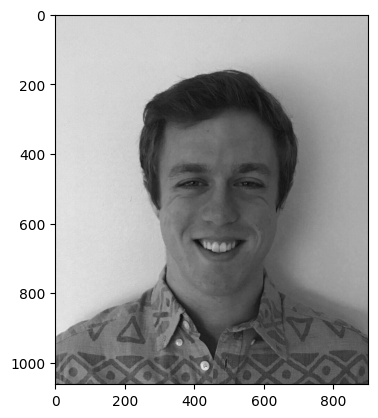

In [63]:
plt.imshow(me, cmap="gray")
plt.show()

Les images MNIST sont centrées et carrées avec une taille définie. Il faut formatter notre image de façon semblable.
La transformation `ToTensor()` normalise l'image et convertit sous forme de tenseur.
Une image non normalisée ne sera pas analysée correctement par le réseau, comme nos donnnées d'entraînement étaient normalisées

**Exercice: Remarquez la dernière ligne de la cellule suivante. À quoi sert-elle? Testez l'inférence sans cette ligne.**

In [64]:
max_ax = int(me.shape[0] < me.shape[1])  # Trouver le plus grand axe d'une image rectangulaire
min_ax = int(not max_ax)  # Trouver le plus petit axe
max_axl = me.shape[max_ax]  # Dimension max
min_axl = me.shape[min_ax]  # Dimension min
ind = [slice(None), slice(None)]  # Indice pour tous les élément
ind[max_ax] = slice(max_axl // 2 - min_axl // 2, max_axl // 2 + min_axl // 2)  # Indice pour l'axe maximum
me_sq = me[tuple(ind)]  # On coupe l'image à un carré
me_lowres = cv2.resize(me_sq, (28, 28))  # On dégrade la résolution à 28x28
img2tensor = ToTensor()  # On convertit en tenseur
me_tensor = img2tensor(me_lowres)
me_tensor = 1 - me_tensor

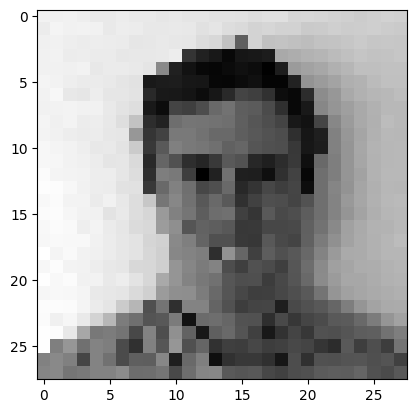

In [65]:
plt.imshow(me_tensor.squeeze().detach(), cmap="binary")
plt.show()

Après, on peut tester la prédiction du modèle sur l'exemple
Encore une fois, le modèle affiche une certaine confiance vers une valeur spécifique.

Catégorie prédite: Shirt, probabilité de 0.330


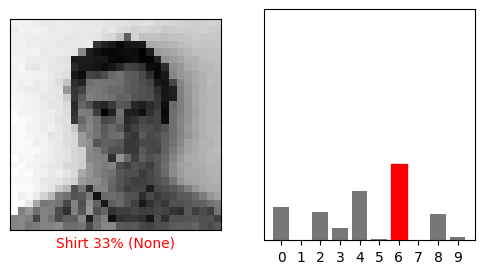

In [66]:
preds = try_model(me_tensor, model)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), None, me_tensor.squeeze().detach(), cmap="binary")
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), None)
plt.show()

On peut répéter l'inférence avec n'importe quelle image ensuite.

Définissons une fonction qui répète les opérations ci-dessus.

In [67]:
def load_image(fpath, inv=False):

    img = cv2.imread(fpath, 0)

    max_ax = int(img.shape[0] < img.shape[1])
    min_ax = int(not max_ax)
    max_axl = img.shape[max_ax]
    min_axl = img.shape[min_ax]
    ind = [slice(None), slice(None)]
    ind[max_ax] = slice(max_axl // 2 - min_axl // 2, max_axl // 2 + min_axl // 2)
    img_sq = img[tuple(ind)]
    img_lowres = cv2.resize(img_sq, (28, 28))
    img2tensor = ToTensor()
    img_tensor = img2tensor(img_lowres)
    if inv:
        img_tensor = 1 - img_tensor

    return img_tensor

Catégorie prédite: Dress, probabilité de 0.313


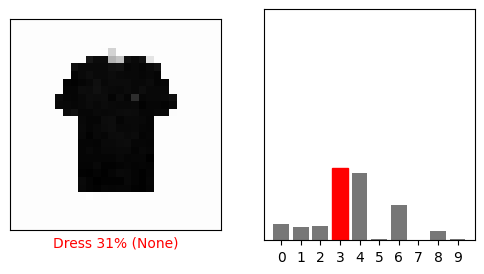

In [68]:
# Ce t-shirt est plus petit au centre de l'image. ça n'aide surement pas. Et il a un motif
dior = load_image("dior.jpg", inv=True)
preds = try_model(dior, model)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), None, dior.squeeze().detach(), cmap="binary")
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), None)
plt.show()

Catégorie prédite: Trouser, probabilité de 0.281


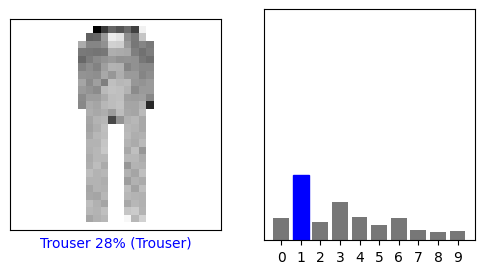

In [69]:
pants = load_image("pants.png")
preds = try_model(pants, model)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), inv_labels_map["Trouser"], pants.squeeze().detach(), cmap="binary")
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), inv_labels_map["Trouser"])
plt.show()

Catégorie prédite: Bag, probabilité de 0.454


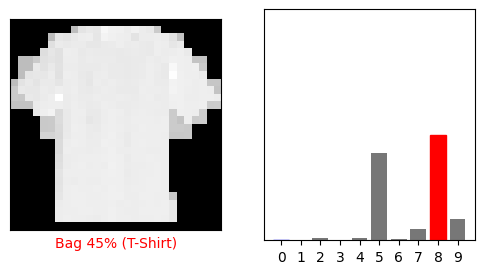

In [70]:
ts_black = load_image("ts_black.png")
preds = try_model(ts_black, model)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), inv_labels_map["T-Shirt"], ts_black.squeeze().detach(), cmap="binary")
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), inv_labels_map["T-Shirt"])
plt.show()

Certaines images font avoir une intensité inverse aux données d'entraînement: on veut s'assurer de les formatter comme il faut.

Catégorie prédite: T-Shirt, probabilité de 0.597


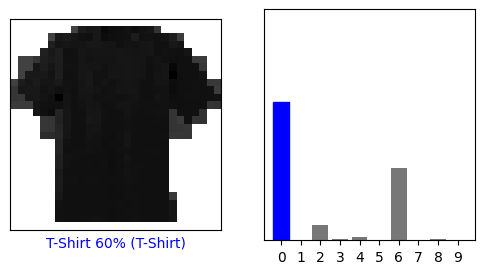

In [71]:
ts_black = load_image("ts_black.png", inv=True)
preds = try_model(ts_black, model)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(preds.squeeze().detach(), inv_labels_map["T-Shirt"], ts_black.squeeze().detach(), cmap="binary")
plt.subplot(1, 2, 2)
plot_value_array(preds.squeeze().detach(), inv_labels_map["T-Shirt"])
plt.show()

## Conclusion

Voilà! En résumé nous avons:

- Appris à importer des images via PyTorch.
- Appris à définir un réseau neuronal pleinement connecté.
- Appris à entraîner ce réseau via une descente de gradient stochastique.
- Appris à utiliser ce réseau pour prédire la valeur de différentes images.

Plusieurs de ces éléments reviendront au cours de la session, notamment dans le TP sur les CNNs et dans le devoir 3.